 In this notebook, we will compare five different 3D face alignment methods based on supervised & unsupervised performance metrics. A detailed performance analysis will be presented. Parts of the codes have been written with the help of this repository: https://github.com/thanhhvnqb/3dface_val

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import json
from scipy.spatial import distance
from numpy import loadtxt
from numpy import linalg as LA
from scipy import stats
import matplotlib
%matplotlib inline
import pylab as plt

## Unsupervised Evaluation metric

In [4]:
# Statistical models' path
models_path = './statistical_frontal_landmark_models/'
# Mean face's path
mean_face_path = './mean_face/'

# Coordinates of eyes' landmarks for normalization purpose
left_eye_inds = (np.arange(36,42)).astype(int)
right_eye_inds = (np.arange(42,48)).astype(int)

mean_face = np.loadtxt(os.path.join(mean_face_path, 'mean_face_new.txt'))
p1 = np.mean(mean_face[left_eye_inds,:], axis = 1)
p2 = np.mean(mean_face[right_eye_inds,:], axis = 1)
normalization_dist = np.sqrt(np.sum((p1 - p2)*(p1 - p2)));

# 4 different statistical landmark models:
model_pool = ['3DFA1_GStudent_EM.txt', '3DFA1_GUM_EM.txt', '3DFA2_GStudent_EM.txt', '3DFA2_GUM_EM.txt']

def EvalFA(pathModel, face):

    with open(pathModel) as json_file:  
        model = json.load(json_file)

    confidences = np.zeros((68,1))
    
    ids = np.arange(68)
    
    if dataset == '3DFAW':
        ids = np.delete(ids, [60,64])
        confidences = np.zeros((66,1))
        
    for i0 , i1 in enumerate(ids):
        landmark = face[i0,:]
        center = np.array(model['center'][i1])
        
        covmat = np.array(model['cov_matrix'][i1])
        
        A = LA.inv(covmat)
        confidences[i0] = distance.mahalanobis(landmark,center, A)/3.0 #3.0
         
    return confidences

## Supervised Evaluation metric

In [5]:
import time
import sys
import os
from os import listdir, makedirs
from os.path import isfile, join, isdir
import pickle
import gzip

import numpy as np
import matplotlib.pylab as plt
import matplotlib
import scipy.io as sio
from tqdm import tqdm


# 3D bounding box computation
def getBBsize3D(points):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    bbsize = maxs - mins
    normby = np.sqrt(bbsize[0] * bbsize[1] * bbsize[2])
    return np.sqrt(bbsize[0] * bbsize[1] * bbsize[2])

# 2D bounding box computation
def getBBsize2D(points):
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    bbsize = maxs - mins
    normby = np.sqrt(bbsize[0] * bbsize[1])
    return np.sqrt(bbsize[0] * bbsize[1])

# normalization distance between eyes' centers
def getNormDist(points):
    left_eye_inds = np.arange(36,42)
    right_eye_inds = np.arange(42,48)
    # compute the distance between the two eyes as a normalization constant
    p1 = np.mean(points[left_eye_inds, :], axis = 0)
    p2 = np.mean(points[right_eye_inds, :], axis = 0)
    normalization_dist = np.sqrt(np.sum((p1 - p2)*(p1 - p2)));
    return normalization_dist
    
# 3D distance computation with bounding box normalization
def calcDistance3D(pred, gt_pts):
    bbsize = getBBsize3D(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / bbsize

# 3D distance computation with bounding box normalization + centering of z coordinates
def calcDistance3Dminus(pred, gt_pts):
    pred[:,2] -= np.mean(pred[:,2])
    gt_pts[:,2] -= np.mean(gt_pts[:,2])    
    bbsize = getBBsize3D(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / bbsize

# 2D distance computation with bounding box normalization
def calcDistance2D(pred, gt_pts):
    bbsize = getBBsize2D(gt_pts[:,:2])
    return np.linalg.norm(pred[:,:2] - gt_pts[:,:2], axis=1) / bbsize

# 2D distance computation with eyes' distance normalization
def calcDistanceE2D(pred, gt_pts):
    norm_dist = getNormDist(gt_pts[:,:2])
    return np.linalg.norm(pred[:,:2] - gt_pts[:,:2], axis=1) / norm_dist

# 3D distance computation with eyes' distance normalization
def calcDistanceE3D(pred, gt_pts):
    norm_dist = getNormDist(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / norm_dist

# 3D distance computation with eyes' distance normalization + centering of z coordinates
def calcDistanceE3Dminus(pred, gt_pts):
    pred[:,2] -= np.mean(pred[:,2])
    gt_pts[:,2] -= np.mean(gt_pts[:,2])
    norm_dist = getNormDist(gt_pts)
    return np.linalg.norm(pred - gt_pts, axis=1) / norm_dist

## Unsupervised error computation

In [39]:
# compute the unsupervised metric

model_pool = ['3DFA1_GStudent_EM.txt', '3DFA1_GUM_EM.txt', '3DFA2_GStudent_EM.txt', '3DFA2_GUM_EM.txt']

# which statistical face model from the model pool to use:
model_id = 3


pathModel = os.path.join(models_path, model_pool[model_id])

with open(pathModel) as json_file:  
    model = json.load(json_file)
        
centers = np.array(model['center']).squeeze()

       
dataset = 'AFLW2000' 
align_method = 'student' # student gum

ldks_folder = '../results/'

input_folder = './AFLW2000'

file_list = [f for f in os.listdir(input_folder) if f.endswith('.mat')]

err_gtU = {}    
err_bulatU = {}
err_prnetU = {}
err_3ddfaU = {}
err_3ddfa_v2U = {}
err_2daslU = {}

for file_ in file_list:
    
    file_ = os.path.join(input_folder, file_)
    
    bpath, fname = os.path.split(file_)
    
    file0 = os.path.join(ldks_folder,'aligned_ldks_GT',str(fname[:-4])+'_'+str(align_method)+'.txt')
    file1 = os.path.join(ldks_folder,'aligned_ldks_Bulat',str(fname[:-4])+'_'+str(align_method)+'.txt')
    file2 = os.path.join(ldks_folder,'aligned_ldks_PRNET',str(fname[:-4])+'_'+str(align_method)+'.txt')
    file3 = os.path.join(ldks_folder,'aligned_ldks_3DDFA',str(fname[:-4])+'_'+str(align_method)+'.txt')
    file4 = os.path.join(ldks_folder,'aligned_ldks_2DASL',str(fname[:-4])+'_'+str(align_method)+'.txt')
    file5 = os.path.join(ldks_folder,'aligned_ldks_3DDFA_V2',str(fname[:-4])+'_'+str(align_method)+'.txt')
    
    if os.path.isfile(file1) and os.path.isfile(file2) and os.path.isfile(file3) and os.path.isfile(file4) and os.path.isfile(file5):
        ldmrks0 = loadtxt(file0)
        ldmrks1 = loadtxt(file1)
        ldmrks2 = loadtxt(file2)
        ldmrks3 = loadtxt(file3)
        ldmrks4 = loadtxt(file4)
        ldmrks5 = loadtxt(file5)
        
    if not ldmrks2.size or not ldmrks1.size or not ldmrks3.size or not ldmrks4.size or not ldmrks5.size:
        continue

    err_gtU[str(fname)] = EvalFA(pathModel, ldmrks0)    
    err_bulatU[str(fname)] = EvalFA(pathModel, ldmrks1)
    err_prnetU[str(fname)] = EvalFA(pathModel, ldmrks2)
    err_3ddfaU[str(fname)] = EvalFA(pathModel, ldmrks3)
    err_2daslU[str(fname)] = EvalFA(pathModel, ldmrks4)
    err_3ddfa_v2U[str(fname)] = EvalFA(pathModel, ldmrks5)

## Supervised error computation

In [40]:
# compute the supervised metric
err_type = 'E3Dminus' # see Section "Supervised Evaluation metric" above

ldks_folder = './results/'

input_folder = './AFLW2000'

file_list = [f for f in os.listdir(input_folder) if f.endswith('.mat')]
   
err_bulatS = {}
err_prnetS = {}
err_3ddfaS = {}
err_3ddfa_v2S = {}
err_2daslS = {}

for file_ in file_list:
    
    file_ = os.path.join(input_folder, file_)
    
    bpath, fname = os.path.split(file_)
    
    pts_gt_file = input_folder + '/' + os.path.basename(file_)
    file1 = os.path.join(ldks_folder,'ldks_Bulat',str(fname[:-4])+'.jpg.txt')
    file2 = os.path.join(ldks_folder,'ldks_PRNET',str(fname[:-4])+'.txt')
    file3 = os.path.join(ldks_folder,'ldks_3DDFA',str(fname[:-4])+'.txt')
    file4 = os.path.join(ldks_folder,'ldks_2DASL',str(fname[:-4])+'.txt')
    file5 = os.path.join(ldks_folder,'ldks_3DDFA_V2',str(fname[:-4])+'.txt')
    
    if os.path.isfile(file1) and os.path.isfile(file2) and os.path.isfile(file3) and os.path.isfile(file4) and os.path.isfile(file5):
        
        ldmrks0 = sio.loadmat(pts_gt_file)['pt3d_68'].T
        ldmrks1 = loadtxt(file1)
        ldmrks2 = loadtxt(file2)
        ldmrks3 = loadtxt(file3).T
        ldmrks4 = loadtxt(file4).T
        ldmrks5 = loadtxt(file5)
        
    else:
        continue
    
    if not ldmrks2.size or not ldmrks1.size or not ldmrks3.size or not ldmrks4.size or not ldmrks5.size:
        continue

    if err_type == 'E3Dminus':
        
        err_bulatS[str(fname)] = calcDistanceE3Dminus(ldmrks1, ldmrks0).reshape((68, 1))
        err_prnetS[str(fname)] = calcDistanceE3Dminus(ldmrks2, ldmrks0).reshape((68, 1))
        err_3ddfaS[str(fname)] = calcDistanceE3Dminus(ldmrks3, ldmrks0).reshape((68, 1))
        err_2daslS[str(fname)] = calcDistanceE3Dminus(ldmrks4, ldmrks0).reshape((68, 1))
        err_3ddfa_v2S[str(fname)] = calcDistanceE3Dminus(ldmrks5, ldmrks0).reshape((68, 1))
        
    elif err_type == 'E3D':
        
        err_bulatS[str(fname)] = calcDistanceE3D(ldmrks1, ldmrks0).reshape((68, 1))
        err_prnetS[str(fname)] = calcDistanceE3D(ldmrks2, ldmrks0).reshape((68, 1))
        err_3ddfaS[str(fname)] = calcDistanceE3D(ldmrks3, ldmrks0).reshape((68, 1))
        err_2daslS[str(fname)] = calcDistanceE3D(ldmrks4, ldmrks0).reshape((68, 1))
        err_3ddfa_v2S[str(fname)] = calcDistanceE3D(ldmrks5, ldmrks0).reshape((68, 1))    
        
    elif err_type == '3Dminus':
        
        err_bulatS[str(fname)] = calcDistance3Dminus(ldmrks1, ldmrks0).reshape((68, 1))
        err_prnetS[str(fname)] = calcDistance3Dminus(ldmrks2, ldmrks0).reshape((68, 1))
        err_3ddfaS[str(fname)] = calcDistance3Dminus(ldmrks3, ldmrks0).reshape((68, 1))
        err_2daslS[str(fname)] = calcDistance3Dminus(ldmrks4, ldmrks0).reshape((68, 1))
        err_3ddfa_v2S[str(fname)] = calcDistance3Dminus(ldmrks5, ldmrks0).reshape((68, 1))
        
    elif err_type == '3D':
        
        err_bulatS[str(fname)] = calcDistance3D(ldmrks1, ldmrks0).reshape((68, 1))
        err_prnetS[str(fname)] = calcDistance3D(ldmrks2, ldmrks0).reshape((68, 1))
        err_3ddfaS[str(fname)] = calcDistance3D(ldmrks3, ldmrks0).reshape((68, 1))
        err_2daslS[str(fname)] = calcDistance3D(ldmrks4, ldmrks0).reshape((68, 1))
        err_3ddfa_v2S[str(fname)] = calcDistance3D(ldmrks5, ldmrks0).reshape((68, 1))        

## Performance analysis

In [41]:
input_folder = '/srv/storage/talc@talc-data.nancy/multispeech/corpus/FaceData/AFLW2000'
file_list = [file for file in os.listdir(input_folder)  if file.endswith('.mat')]


err_bulat_s = []
err_prnet_s = []
err_bulat_u = []
err_prnet_u = []
err_gt_u = []
err_3ddfa_s = []
err_3ddfa_u = []
err_2dasl_s = []
err_2dasl_u = []
err_3ddfa_v2_s = []
err_3ddfa_v2_u = []

fname_lists = []

thr_s = 0.15 # threshold for supervised metric
thr_u = 1.0  # threshold for unsupervised metric

for fname in file_list:
    
    if fname in err_bulatS and fname in err_prnetS and fname in err_3ddfaS and fname in err_2daslS and fname in err_3ddfa_v2S:
        err_bulat_s.append(np.sum(err_bulatS[fname]<=thr_s)/68.)
        err_prnet_s.append(np.sum(err_prnetS[fname]<=thr_s)/68.)
        err_3ddfa_s.append(np.sum(err_3ddfaS[fname]<=thr_s)/68.)
        err_2dasl_s.append(np.sum(err_2daslS[fname]<=thr_s)/68.)
        err_3ddfa_v2_s.append(np.sum(err_3ddfa_v2S[fname]<=thr_s)/68.)
        
        err_bulat_u.append(np.sum(err_bulatU[fname]<=thr_u)/68.)
        err_prnet_u.append(np.sum(err_prnetU[fname]<=thr_u)/68.)
        err_3ddfa_u.append(np.sum(err_3ddfaU[fname]<=thr_u)/68.)
        err_2dasl_u.append(np.sum(err_2daslU[fname]<=thr_u)/68.)
        err_3ddfa_v2_u.append(np.sum(err_3ddfa_v2U[fname]<=thr_u)/68.)
        
        err_gt_u.append(np.sum(err_gtU[fname]<=thr_u)/68.)
        
        fname_lists.append(fname)

In [42]:
str_format = "%5.2f | %5.2f |  %5.2f  | %5.2f | %5.2f"
print("  PRNET  | BULAT | 3DDFA | 3DDFA-v2 | 2DASL ")
print(str_format %(stats.pearsonr(errPS, errPU)[0], stats.pearsonr(errBS, errBU)[0], stats.pearsonr(err3S, err3U)[0], stats.pearsonr(err3_v2S, err3_v2U)[0], stats.pearsonr(err2S, err2U)[0]))

  PRNET  | BULAT | 3DDFA | 3DDFA-v2 | 2DASL 
 0.18 |  0.16 |   0.30  |  0.02 |  0.05


## Computing mean of metrics

In [43]:
thr = 0.0 # threshold based on which to remove GT landmarks
errGU = np.asarray(err_gt_u)
errPU = np.asarray(err_prnet_u)[errGU>=thr]
errPS = np.asarray(err_prnet_s)[errGU>=thr]
errBU = np.asarray(err_bulat_u)[errGU>=thr]
errBS = np.asarray(err_bulat_s)[errGU>=thr]
err3U = np.asarray(err_3ddfa_u)[errGU>=thr]
err3S = np.asarray(err_3ddfa_s)[errGU>=thr]
err3_v2U = np.asarray(err_3ddfa_v2_u)[errGU>=thr]
err3_v2S = np.asarray(err_3ddfa_v2_s)[errGU>=thr]
err2U = np.asarray(err_2dasl_u)[errGU>=thr]
err2S = np.asarray(err_2dasl_s)[errGU>=thr]

print('supervised-mean: PRNET {} --- Bulat {} --- 3DDFA {} --- 2DASL {} --- 3DDFA-V2 {}'.format(round(np.mean(errPS),2),round(np.mean(errBS),2),round(np.mean(err3S),2),round(np.mean(err2S),2),round(np.mean(err3_v2S),2)))
print('---------------------------')
print('uunsupervised-mean: PRNET {} --- Bulat {} --- 3DDFA {} --- 2DASL {} --- 3DDFA-V2 {} --- GT {}'.format(round(np.mean(errPU),2),round(np.mean(errBU),2),round(np.mean(err3U),2),round(np.mean(err2U),2),round(np.mean(err3_v2U),2),round(np.mean(errGU),2)))

s-mean: PRNET 0.85 --- Bulat 0.83 --- 3DDFA 0.84 --- 2DASL 0.22 --- 3DDFA-V2 0.85
---------------------------
u-mean: PRNET 0.8 --- Bulat 0.6 --- 3DDFA 0.85 --- 2DASL 0.12 --- 3DDFA-V2 0.86 --- GT 0.64


## Plot correlation and p-values

In [13]:
thrs = np.delete(np.arange(0.0,0.99,0.025),-1)

corr_P = np.zeros((len(thrs),1))
corr_B = np.zeros((len(thrs),1))
corr_3 = np.zeros((len(thrs),1))
corr_3_v2 = np.zeros((len(thrs),1))
corr_2 = np.zeros((len(thrs),1))

pvals_P = np.zeros((len(thrs),1))
pvals_B = np.zeros((len(thrs),1))
pvals_3 = np.zeros((len(thrs),1))
pvals_3_v2 = np.zeros((len(thrs),1))
pvals_2 = np.zeros((len(thrs),1))

for id_ , thr in enumerate(thrs):
    
    errGU = np.asarray(err_gt_u)
    errPU = np.asarray(err_prnet_u)[errGU>=thr]
    errPS = np.asarray(err_prnet_s)[errGU>=thr]
    errBU = np.asarray(err_bulat_u)[errGU>=thr]
    errBS = np.asarray(err_bulat_s)[errGU>=thr]
    err3U = np.asarray(err_3ddfa_u)[errGU>=thr]
    err3S = np.asarray(err_3ddfa_s)[errGU>=thr]
    err3_v2U = np.asarray(err_3ddfa_v2_u)[errGU>=thr]
    err3_v2S = np.asarray(err_3ddfa_v2_s)[errGU>=thr]
    err2U = np.asarray(err_2dasl_u)[errGU>=thr]
    err2S = np.asarray(err_2dasl_s)[errGU>=thr]
    
    [corr_P[id_], pvals_P[id_]] = stats.pearsonr(errPS, errPU)
    [corr_B[id_], pvals_B[id_]] = stats.pearsonr(errBS, errBU)
    [corr_3[id_], pvals_3[id_]] = stats.pearsonr(err3S, err3U)
    [corr_2[id_], pvals_2[id_]] = stats.pearsonr(err2S, err2U)
    [corr_3_v2[id_], pvals_3_v2[id_]] = stats.pearsonr(err3_v2S, err3_v2U)

In [71]:
print('supervised-mean: PRNET {} --- Bulat {} --- 3DDFA {} --- 2DASL {} --- 3DDFA-V2 {}'.format(round(np.mean(errPS),2),round(np.mean(errBS),2),round(np.mean(err3S),2),round(np.mean(err2S),2),round(np.mean(err3_v2S),2)))
print('---------------------------')
print('uunsupervised-mean: PRNET {} --- Bulat {} --- 3DDFA {} --- 2DASL {} --- 3DDFA-V2 {} --- GT {}'.format(round(np.mean(errPU),2),round(np.mean(errBU),2),round(np.mean(err3U),2),round(np.mean(err2U),2),round(np.mean(err3_v2U),2),round(np.mean(errGU),2)))

s-mean: PRNET 0.72 --- Bulat 0.66 --- 3DDFA 0.7 --- 2DASL 0.13 --- 3DDFA-V2 0.68
---------------------------
u-mean: PRNET 0.97 --- Bulat 0.95 --- 3DDFA 0.99 --- 2DASL 0.12 --- 3DDFA-V2 0.99 --- GT 0.86


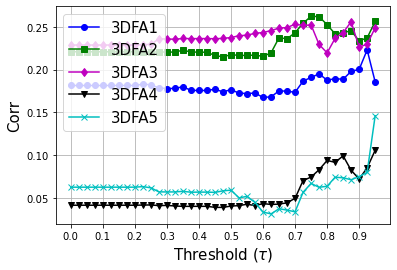

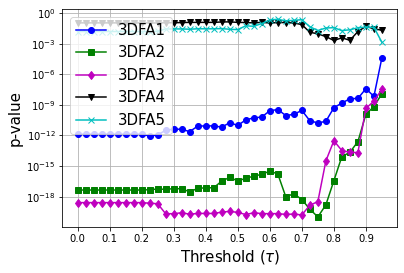

In [52]:
mks = 6
save_folder = './results/NME_plot/corr/'

plt.figure()
plt.plot(thrs, corr_B, '-bo', markersize = mks, label = '3DFA1')
plt.plot(thrs, corr_P,'-gs', markersize = mks, label = '3DFA2')
plt.plot(thrs, corr_3,'-md', markersize = mks, label = '3DFA3')
plt.plot(thrs, corr_2,'-kv', markersize = mks, label = '3DFA4')
plt.plot(thrs, corr_3_v2,'-cx', markersize = mks, label = '3DFA5')
plt.legend(loc=2, prop={'size':15})
plt.xlabel(r'Threshold ($\tau$)', fontsize = 15)
plt.ylabel('Corr', fontsize = 15)
plt.xticks(np.arange(0, thrs[-1],0.1))
plt.grid()

plt.savefig(save_folder + 'corr_mid_' + str(model_id) + '_alm_' + str(align_method) + '_thrs_' + str(thr_s) + '_err_type_' + str(err_type) + '.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.plot(thrs, pvals_B, '-bo', markersize = mks, label = '3DFA1')
plt.plot(thrs, pvals_P,'-gs', markersize = mks, label = '3DFA2')
plt.plot(thrs, pvals_3,'-md', markersize = mks, label = '3DFA3')
plt.plot(thrs, pvals_2,'-kv', markersize = mks, label = '3DFA4')
plt.plot(thrs, pvals_3_v2,'-cx', markersize = mks, label = '3DFA5')
plt.legend(loc=2, prop={'size':15})
plt.xlabel(r'Threshold ($\tau$)', fontsize = 15)
plt.ylabel("p-value", fontsize = 15)
plt.xticks(np.arange(0, thrs[-1],0.1))
plt.yscale('log')
plt.grid()

plt.savefig(save_folder + 'p_value_mid_' + str(model_id) + '_alm_' + str(align_method) + '_thrs_' + str(thr_s) + '_err_type_' + str(err_type) + '.pdf', transparent=True, bbox_inches='tight', pad_inches=0)


# Plot of supervised and unsupervised metrics versus threshold

In [8]:
input_folder = './AFLW2000'
file_list = [file for file in os.listdir(input_folder)  if file.endswith('.mat')]

In [11]:
thr_s_array = np.arange(0.05, 0.35, 0.05)
thr_u_array = np.arange(0.2, 1.6, 0.1)

err_bulat_arrS, err_prnet_arrS, err_3ddfa_arrS, err_2dasl_arrS, err_3ddfa_v2_arrS = np.zeros(len(thr_s_array)), np.zeros(len(thr_s_array)), np.zeros(len(thr_s_array)), np.zeros(len(thr_s_array)), np.zeros(len(thr_s_array))

for id_s, thr_s in enumerate(thr_s_array):
    
    err_bulat_s = []
    err_prnet_s = []
    err_3ddfa_s = []
    err_2dasl_s = []
    err_3ddfa_v2_s = []


    for fname in file_list:

        if fname in err_bulatS and fname in err_prnetS and fname in err_3ddfaS and fname in err_2daslS and fname in err_3ddfa_v2S:
            err_bulat_s.append(np.sum(err_bulatS[fname]<=thr_s)/68.)
            err_prnet_s.append(np.sum(err_prnetS[fname]<=thr_s)/68.)
            err_3ddfa_s.append(np.sum(err_3ddfaS[fname]<=thr_s)/68.)
            err_2dasl_s.append(np.sum(err_2daslS[fname]<=thr_s)/68.)
            err_3ddfa_v2_s.append(np.sum(err_3ddfa_v2S[fname]<=thr_s)/68.)

    err_bulat_arrS[id_s] = round(np.mean(np.asarray(err_bulat_s)),2)
    err_prnet_arrS[id_s] = round(np.mean(np.asarray(err_prnet_s)),2)
    err_3ddfa_arrS[id_s] = round(np.mean(np.asarray(err_3ddfa_s)),2)
    err_2dasl_arrS[id_s] = round(np.mean(np.asarray(err_2dasl_s)),2)
    err_3ddfa_v2_arrS[id_s] = round(np.mean(np.asarray(err_3ddfa_v2_s)),2)
    
err_bulat_arrU, err_prnet_arrU, err_3ddfa_arrU, err_2dasl_arrU, err_3ddfa_v2_arrU, err_gt_arrU = np.zeros(len(thr_u_array)), np.zeros(len(thr_u_array)), np.zeros(len(thr_u_array)), np.zeros(len(thr_u_array)), np.zeros(len(thr_u_array)), np.zeros(len(thr_u_array))

for id_u, thr_u in enumerate(thr_u_array):
    
    err_bulat_u = []
    err_prnet_u = []
    err_gt_u = []
    err_3ddfa_u = []
    err_2dasl_u = []
    err_3ddfa_v2_u = []


    for fname in file_list:

        if fname in err_bulatU and fname in err_prnetU and fname in err_3ddfaU and fname in err_2daslU and fname in err_3ddfa_v2U:

            err_bulat_u.append(np.sum(err_bulatU[fname]<=thr_u)/68.)
            err_prnet_u.append(np.sum(err_prnetU[fname]<=thr_u)/68.)
            err_3ddfa_u.append(np.sum(err_3ddfaU[fname]<=thr_u)/68.)
            err_2dasl_u.append(np.sum(err_2daslU[fname]<=thr_u)/68.)
            err_3ddfa_v2_u.append(np.sum(err_3ddfa_v2U[fname]<=thr_u)/68.)

            err_gt_u.append(np.sum(err_gtU[fname]<=thr_u)/68.)
        
    err_bulat_arrU[id_u] = round(np.mean(np.asarray(err_bulat_u)),2)
    err_prnet_arrU[id_u] = round(np.mean(np.asarray(err_prnet_u)),2)
    err_3ddfa_arrU[id_u] = round(np.mean(np.asarray(err_3ddfa_u)),2)
    err_2dasl_arrU[id_u] = round(np.mean(np.asarray(err_2dasl_u)),2)
    err_3ddfa_v2_arrU[id_u] = round(np.mean(np.asarray(err_3ddfa_v2_u)),2)        
    err_gt_arrU[id_u] = round(np.mean(np.asarray(err_gt_u)),2)
        

## Plot the results

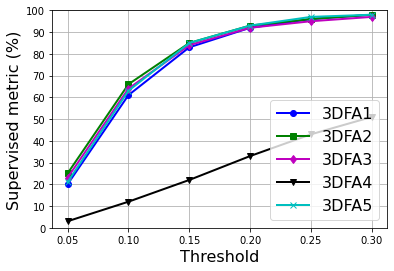

In [13]:
# Supervised metric

mks = 6
mk_eve = 1
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.xticks(thr_s_array)
plt.grid()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Supervised metric (%)', fontsize=16)
plt.plot(thr_s_array,err_bulat_arrS*100,'-bo',label='3DFA1', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_s_array,err_prnet_arrS*100,'-gs',label='3DFA2', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_s_array,err_3ddfa_arrS*100,'-md',label='3DFA3', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_s_array,err_2dasl_arrS*100,'-kv',label='3DFA4', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_s_array,err_3ddfa_v2_arrS*100,'-cx',label='3DFA5', markersize = mks, markevery=mk_eve, lw=2)

plt.legend(loc=4, fontsize=16)
plt.savefig('./results/NME_plot/Supervised_metric.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

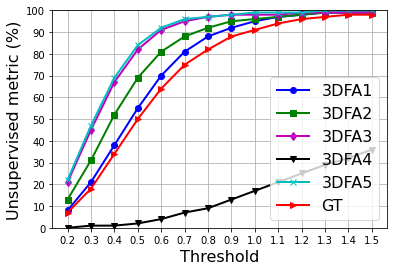

In [12]:
# Unupervised metric

mks = 6
mk_eve = 1
plt.ylim(0,100)
plt.yticks(np.arange(0,110,10))
plt.xticks(thr_u_array)
plt.grid()
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Unsupervised metric (%)', fontsize=16)
plt.plot(thr_u_array,err_bulat_arrU*100,'-bo',label='3DFA1', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_u_array,err_prnet_arrU*100,'-gs',label='3DFA2', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_u_array,err_3ddfa_arrU*100,'-md',label='3DFA3', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_u_array,err_2dasl_arrU*100,'-kv',label='3DFA4', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_u_array,err_3ddfa_v2_arrU*100,'-cx',label='3DFA5', markersize = mks, markevery=mk_eve, lw=2)
plt.plot(thr_u_array,err_gt_arrU*100,'-r>',label='GT', markersize = mks, markevery=mk_eve, lw=2)

plt.legend(loc=4, fontsize=16)
plt.savefig('./results/NME_plot/Unsupervised_metric_withGT_mid_'  + str(model_id) + '_alm_' + str(align_method) + '.pdf', transparent=True, bbox_inches='tight', pad_inches=0)